In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_dir="E:\Transfer Learning\data\hymenoptera_data"

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 243, 'val': 153}

In [5]:
class_names = image_datasets['train'].classes
class_names

['ants', 'bees']

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [8]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

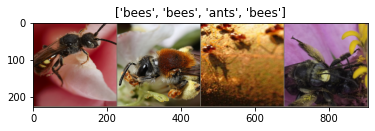

In [9]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5264 Acc: 0.7449
val Loss: 0.2100 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5613 Acc: 0.7695
val Loss: 0.3937 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.5474 Acc: 0.7572
val Loss: 0.2689 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5083 Acc: 0.8148
val Loss: 0.4500 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.5394 Acc: 0.7819
val Loss: 0.2555 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4204 Acc: 0.8519
val Loss: 0.6273 Acc: 0.7582

Epoch 6/24
----------
train Loss: 0.5598 Acc: 0.8025
val Loss: 0.2453 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3084 Acc: 0.8889
val Loss: 0.1671 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3732 Acc: 0.8354
val Loss: 0.1422 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4306 Acc: 0.8189
val Loss: 0.1441 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2449 Acc: 0.8930
val Loss: 0.1527 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2963 Acc: 0.8848
val Loss: 0.1338 Acc: 0.9477

Ep

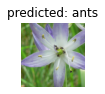

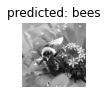

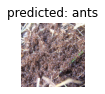

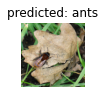

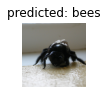

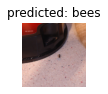

In [14]:
visualize_model(model_ft)

In [15]:
# ConvNet as fixed feature extractor
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6780 Acc: 0.6255
val Loss: 0.2595 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4563 Acc: 0.8025
val Loss: 0.2510 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4065 Acc: 0.8066
val Loss: 0.1843 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4101 Acc: 0.8272
val Loss: 0.2106 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4424 Acc: 0.7901
val Loss: 0.2530 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4353 Acc: 0.8189
val Loss: 0.4067 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.4489 Acc: 0.8436
val Loss: 0.2198 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3643 Acc: 0.8519
val Loss: 0.2169 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2580 Acc: 0.8889
val Loss: 0.1896 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3946 Acc: 0.8395
val Loss: 0.2172 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3625 Acc: 0.8272
val Loss: 0.2025 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3143 Acc: 0.8519
val Loss: 0.2113 Acc: 0.9412

Ep

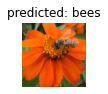

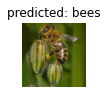

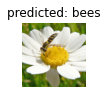

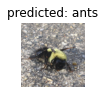

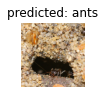

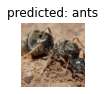

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()